In [1]:
# Install the library

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


In [2]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

In [3]:
# Load the dataset
df = pd.read_csv('./Comerciantes_Bazurto.csv', delimiter=',', encoding='utf-8')

df = df.fillna('NS/NR')

## Preparación de los datos para ser analizados

In [4]:
# List of columns related to types of products or services (updated)
with open('productos.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

columnas_productos = data['columnas_productos']

# Function to extract only the category (what is between "/" and "(")
def extraer_categoria(col_name):
    # Regular expression to capture the text between "/" and "("
    match = re.search(r'/([^/]+?)(?:\s*\(|$)', col_name)
    # ¿Qué tipo de productos vende?/(fjbjpsn)
    # Artículos de ferretería, pinturas y productos de vidrio
    if match:
        return match.group(1).strip()
    return col_name

# Function to combine columns into one
def combinar_productos(row):
    for col in columnas_productos:
        if row[col] == 1:
            return extraer_categoria(col)  # Return the name of the column that has 1
    return 'Otro'  # If none has 1, return "Otro"

# Create a new combined column
df['Tipo de producto/servicio'] = df.apply(combinar_productos, axis=1)


C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\2886564077.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Tipo de producto/servicio'] = df.apply(combinar_productos, axis=1)


In [5]:
# Columnas a extraer
with open('municipios.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

columnas_municipio = data['columnas_municipio']

# Columna de país (colocaremos "Colombia" si está vacía)
df['País'] = df['¿Qué país?'].fillna('Colombia')

# Tomar la columna del municipio no vacía
df['Municipio'] = df[columnas_municipio].fillna('').apply(lambda row: next((x for x in row if x), ''), axis=1)

# Columna de departamento: simplemente copiar desde "¿En qué departamento queda el municipio?"
df['Departamento'] = df['¿En qué departamento queda el municipio?'].fillna('')

# Columna de "¿Es usted cartagenero?" con ajuste de Cartagena y Bolívar
df['Eres_Cartagenero'] = df['¿Es usted cartagenero?'].fillna('')

# Si la respuesta es "Sí" (Cartagenero), asignar Cartagena y Bolívar
df.loc[df['Eres_Cartagenero'].str.contains('Sí', case=False, na=False), ['Municipio', 'Departamento', 'País']] = ['Cartagena', 'Bolívar', 'Colombia']

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\3167623754.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['País'] = df['¿Qué país?'].fillna('Colombia')
C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\3167623754.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Municipio'] = df[columnas_municipio].fillna('').apply(lambda row: next((x for x in row if x), ''), axis=1)
C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\3167623754.py:14: PerformanceWarning: DataFrame is highly fragmente

In [6]:
# Cambio de lugar de residencia
df['motivo_de_cambio'] = df.apply(
    lambda row: row['Otra razón de cambio lugar de residencia.'] if row['¿Cuál fue el principal motivo por el que cambió su lugar de residencia?/Otro, ¿cuál?'] == 1 and row[
        'Otra razón de cambio lugar de residencia.'] != '' else row['¿Cuál fue el principal motivo por el que cambió su lugar de residencia?'],
    axis=1
)

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\1940116935.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['motivo_de_cambio'] = df.apply(


In [7]:

# Definición de columnas
columnas_eps = [
    "¿Está afiliado(a) a alguna entidad de seguridad social en salud (EPS) ?",
    "¿A cuál de los siguientes regímenes de seguridad social en salud está afiliado?:",
    "¿Alguna vez ha estado afiliado(a), como cotizante o beneficiario(a), a alguna entidad de seguridad social en salud?"
]

# Función para determinar el estado de afiliación
def combinar_eps(row):
    # Verificar si todas las columnas son 'NO' o están vacías
    if (row[columnas_eps[0]] in ['NO', '', 'NS/NR'] and
        row[columnas_eps[1]] in ['NO', '', 'NS/NR'] and
        row[columnas_eps[2]] in ['NO', '', 'NS/NR']):
        return 'No afiliado'
    
    for col in columnas_eps:
        # Asegurarse de que el valor no esté vacío y sea un string
        if isinstance(row[col], str) and row[col].startswith('SI'):
            # Retornar el tipo de afiliación según el régimen
            if row[columnas_eps[1]]:  # Verificar que no esté vacío
                if 'Subsidiado' in row[columnas_eps[1]]:
                    return 'Subsidiado'
                elif 'Contributivo' in row[columnas_eps[1]]:
                    return 'Contributivo'
            return row[columnas_eps[1]]

    return 'Sin datos'  # En caso de que no se encuentren datos

# Crear una nueva columna agrupada
df['Afiliación a EPS'] = df.apply(combinar_eps, axis=1)

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\2099686905.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Afiliación a EPS'] = df.apply(combinar_eps, axis=1)


In [8]:
# Transporte
transporte = [
    "¿Qué medio de transporte utiliza principalmente para desplazarse a su sitio de trabajo/Mercado?",
    "Otro medio de transporte. ¿Cuál?"
]

# Función para combinar columnas de transporte
def combinar_transporte(row):
    if row[transporte[0]] == 'Otro.':
        return row[transporte[1]]
    return row[transporte[0]]

# Crear una nueva columna de transporte
df['Medio de transporte'] = df.apply(combinar_transporte, axis=1)


C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\3994894657.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Medio de transporte'] = df.apply(combinar_transporte, axis=1)


In [ ]:
# Columnas de escolaridad
columnas_escolaridad = [
    "¿Tiene diploma de alguno de los siguientes niveles de escolaridad?",
    "¿Hasta que curso logró completar?"
]

def agrupar_escolaridad(row):
    if pd.isnull(row[columnas_escolaridad[0]]) or pd.isnull(row[columnas_escolaridad[1]]):
        return 'NS/NR'
    
    # Si no tiene diploma, evaluar el curso completado
    if row[columnas_escolaridad[0]] == 'Ninguno':
        curso = row[columnas_escolaridad[1]]

        if curso == 'NS/NR':
            return 'NS/NR'
        elif '1°' <= curso <= '4°':
            return 'Primaria incompleta'
        elif curso == '5°' or curso == 'Básica primaria (1.°-5.°)':
            return 'Primaria completa'
        elif '6°' <= curso <= '9°' or curso == 'Basíca secundaria (6.° - 9.°)':
            return 'Básica completa'
        elif curso == 'Media (10.° - 13.°)':
            return 'Media completa'
        else:
            return 'Bachillerato completo'
    
    # Si tiene diploma, devolver lo que hay en la columna
    return row[columnas_escolaridad[0]]

# Crear una nueva columna de escolaridad
df['Nivel de escolaridad'] = df.apply(agrupar_escolaridad, axis=1)


C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\922574986.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Nivel de escolaridad'] = df.apply(agrupar_escolaridad, axis=1)


In [10]:
# Seguridad social

columnas_seguridad_social = [
    "¿Está cotizando en alguna entidad de seguridad social en pensiones?",
    "¿Alguna vez ha cotizado en alguna entidad de seguridad social en pensiones?",
    "¿Está afiliado(a) a alguna entidad de seguridad social en riesgos laborales (ARL)?",
    "¿Alguna vez ha estado afiliado(a) a una entidad de seguridad social en riesgos laborales (ARL)?"
]


def validar_seguridad_social(row):
    if not row[columnas_seguridad_social[0]] and not row[columnas_seguridad_social[1]] and not row[columnas_seguridad_social[2]] and not  row[columnas_seguridad_social[3]]:
        return 'No afiliado'
    else:
        return 'Afiliado'


df['seguridad social sin salud'] = df.apply(validar_seguridad_social, axis=1)

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\2705032793.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['seguridad social sin salud'] = df.apply(validar_seguridad_social, axis=1)


In [11]:
# Manejo de basuras

columnas_basuras = [
    "¿Qué hace con la basura que produce en el desarrollo de su actividad económica/local?",
    "Otro. ¿Cuál?...416"
]

def validar_basuras(row):
    if row[columnas_basuras[0]] == 'Otro. ¿Cuál?':
        return row[columnas_basuras[1]]
    return row[columnas_basuras[0]]

df['Manejo de basuras'] = df.apply(validar_basuras, axis=1)

C:\Users\Esneider Guzman\AppData\Local\Temp\ipykernel_18256\2956578868.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Manejo de basuras'] = df.apply(validar_basuras, axis=1)


In [12]:
# Manejo de trabajadores

columnas_trabajadores = [
    "¿Cuántos trabajadores extranjeros tiene?"
]

def validar_trabajadores(row):
    if row[columnas_trabajadores[0]] == 'NS/NR':
        return 0
    
    return row[columnas_trabajadores[0]]

df['¿Cuántos trabajadores extranjeros tiene?'] = df.apply(validar_trabajadores, axis=1)

# Manejo de ruv

columnas_ruv = [
    "¿Está inscrito en el Registro Único de Víctimas - RUV?"
]

def validar_ruv(row):
    if row[columnas_ruv[0]] == 'NS/NR':
        return 'NO'
    
    
    return row[columnas_ruv[0]]

df['¿Está inscrito en el Registro Único de Víctimas - RUV?'] = df.apply(validar_ruv, axis=1)

# Discapacidad

columnas_discapacidad = [
    "¿Qué tipo(s) de discapacidad tiene?"
]

def validar_discapacidad(row):
    if row[columnas_discapacidad[0]] == 'NS/NR':
        return 'Sin discapacidad'
    
    return row[columnas_discapacidad[0]]

df['¿Qué tipo(s) de discapacidad tiene?'] = df.apply(validar_discapacidad, axis=1)


# Columnas de contratos

columnas_contratos = [
    "En su mayoría, ¿qué tipo de contrato tienen sus trabajadores?",
    "En su mayoría, ¿los contratos de trabajo son a término indefinido o a término fijo?"
]

def validar_contratos(row):
    if row[columnas_contratos[0]] == 'No sabe, no informa':
        return 'NS/NR'
    
    return row[columnas_contratos[0]]

def validar_tipos_de_contratos(row):
    if row[columnas_contratos[1]] == 'NS/NR':
        return 'Sin información'


df['En su mayoría, ¿qué tipo de contrato tienen sus trabajadores?'] = df.apply(validar_contratos, axis=1)
df['En su mayoría, ¿los contratos de trabajo son a término indefinido o a término fijo?'] = df.apply(validar_tipos_de_contratos, axis=1)

In [13]:
# cambiar nombres

nombres = {
    "¿Es Ud. Victima del Conflicto o Persona en Situación de Discapacidad?/Persona en situación de discapacidad": "Discapacidad",
    "¿Es Ud. Victima del Conflicto o Persona en Situación de Discapacidad?/Víctima del conflicto armado": "Víctima del conflicto",
    "¿Ud. Se autoreconoce en algunos de los siguientes grupos etnicos?": "Grupo étnico",
    "¿Está inscrito en el Registro Único de Víctimas - RUV?": "RUV",
    "¿Qué tipo(s) de discapacidad tiene?": "Tipo de discapacidad",
    "¿Cuántos años cumplidos tiene?": "Edad",
    "Cuál es su género?": "Genero",
}

df.rename(columns=nombres, inplace=True)

with open('delete.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

delete = data['delete']
df.drop(columns=columnas_productos + columnas_municipio +
        delete + columnas_eps + transporte + columnas_escolaridad + columnas_basuras, inplace=True)

# Crear un diccionario con el índice y el nombre de las columnas
column_dict = {i: col for i, col in enumerate(df.columns)}

# Guardar el diccionario como un archivo JSON
with open('columnas.json', 'w', encoding='utf-8') as json_file:
    json.dump(column_dict, json_file, ensure_ascii=False, indent=4)

# Analisis de datos y muestreo de variables

   _index                   fecha  Edad     Genero               Grupo étnico  \
0       1  08/22/2021 12:00:00 AM    44  Masculino  Ninguno de los anteriores   
1       2  08/22/2021 12:00:00 AM    63   Femenino  Ninguno de los anteriores   
2       3  08/22/2021 12:00:00 AM    39  Masculino  Ninguno de los anteriores   
3       4  08/22/2021 12:00:00 AM    48  Masculino  Ninguno de los anteriores   
4       5  08/22/2021 12:00:00 AM    40   Femenino  Ninguno de los anteriores   

   Víctima del conflicto RUV Tipo de discapacidad ¿Cuenta con SISBEN?  \
0                      0  NO     Sin discapacidad                  NO   
1                      0  NO     Sin discapacidad                  NO   
2                      0  NO     Sin discapacidad                  SI   
3                      1  SI     Sin discapacidad                  SI   
4                      0  NO     Sin discapacidad                  SI   

  ¿Cuál es el parentesco suyo con el jefe o jefa del hogar en su vivienda?

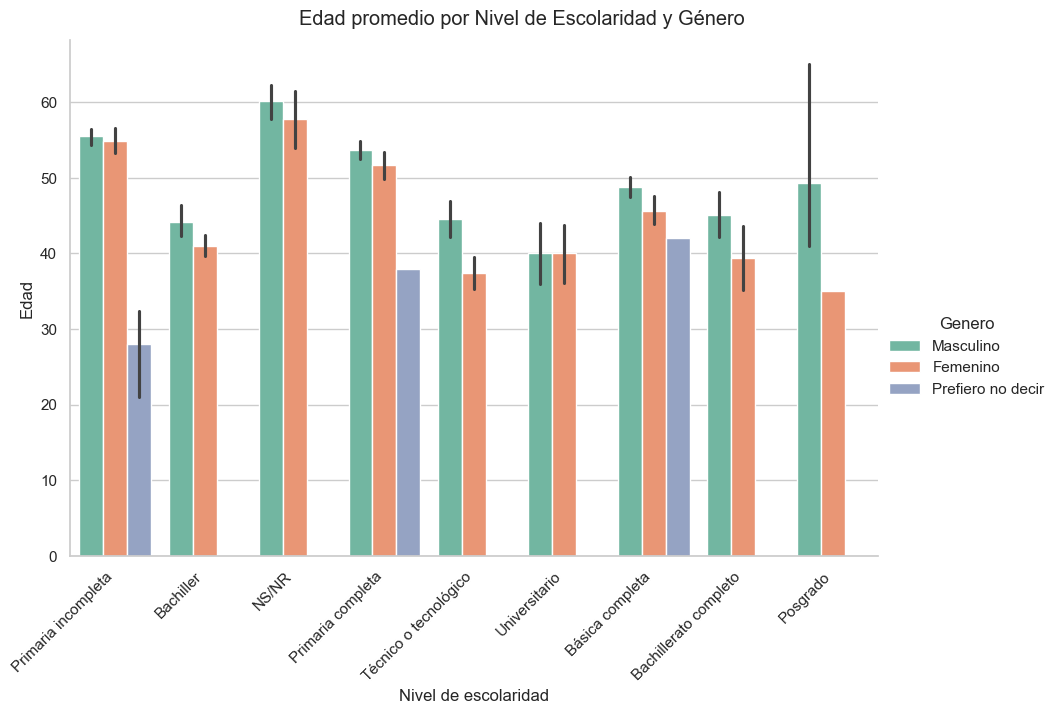

In [14]:
print(df.head())


sns.set(style="whitegrid")

# Crear un catplot de barras agrupadas por género
g = sns.catplot(
    data=df, 
    x="Nivel de escolaridad", 
    y="Edad", 
    hue="Genero", 
    kind="bar", 
    height=6, 
    aspect=1.5, 
    palette="Set2",
)

# Rotar los nombres de los niveles de escolaridad para que se vean mejor
g.set_xticklabels(rotation=45, ha="right")

# Título general
g.fig.suptitle('Edad promedio por Nivel de Escolaridad y Género', y=1.02)

# Mostrar la gráfica
plt.show()


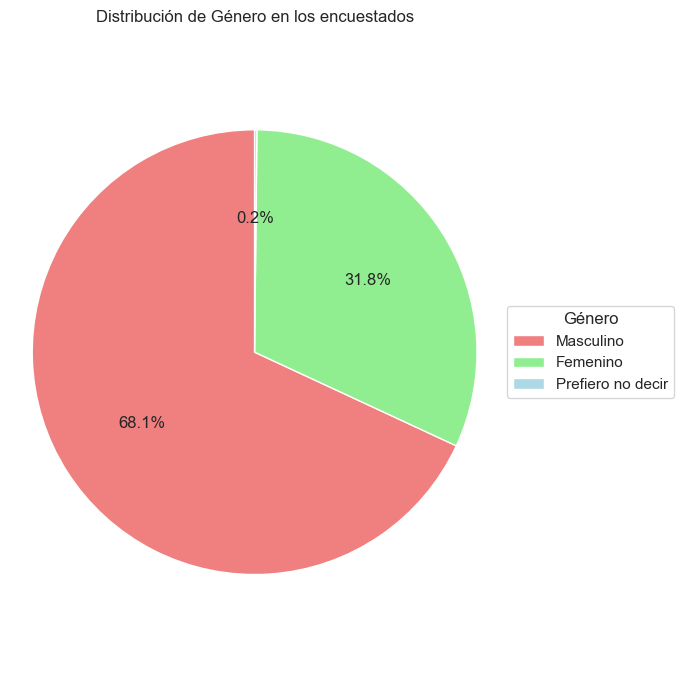

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Contar cuántos encuestados hay por cada género
count_masculino = df[df['Genero'] == 'Masculino'].shape[0]
count_femenino = df[df['Genero'] == 'Femenino'].shape[0]
count_prefiero_no_decir = df[df['Genero'] == 'Prefiero no decir'].shape[0]

# Crear los datos para el gráfico
labels = ['Masculino', 'Femenino', 'Prefiero no decir']
sizes = [count_masculino, count_femenino, count_prefiero_no_decir]
colors = ['lightcoral', 'lightgreen', 'lightblue']

# Crear gráfico de torta
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90)

# Asegurarse de que el gráfico sea un círculo
plt.axis('equal')

# Añadir leyenda al lado derecho
plt.legend(wedges, labels, title="Género", loc="center left", bbox_to_anchor=(1, 0.5))

# Título
plt.title('Distribución de Género en los encuestados')

# Mostrar gráfico
plt.tight_layout()
plt.show()


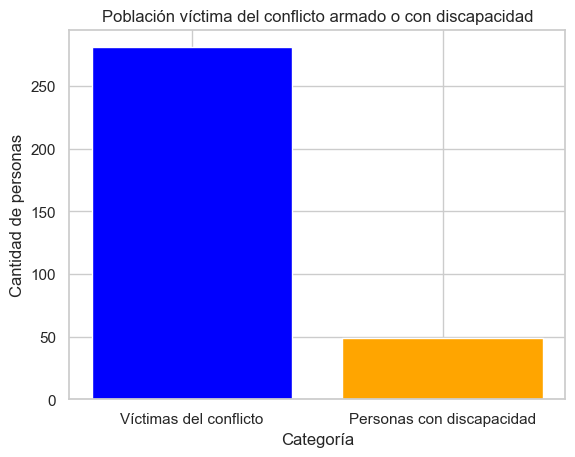

In [16]:
victimas_conflicto = df[df["Víctima del conflicto"] == 1]
personas_discapacidad = df[df["Tipo de discapacidad"] != "Sin discapacidad"]

victimas_o_discapacidad = pd.concat([victimas_conflicto, personas_discapacidad]).drop_duplicates()


data = {
    'Víctimas del conflicto': victimas_conflicto.shape[0],
    'Personas con discapacidad': personas_discapacidad.shape[0]
}

# Crear gráfico de barras
plt.bar(data.keys(), data.values(), color=['blue', 'orange'])
plt.title('Población víctima del conflicto armado o con discapacidad')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de personas')
plt.show()

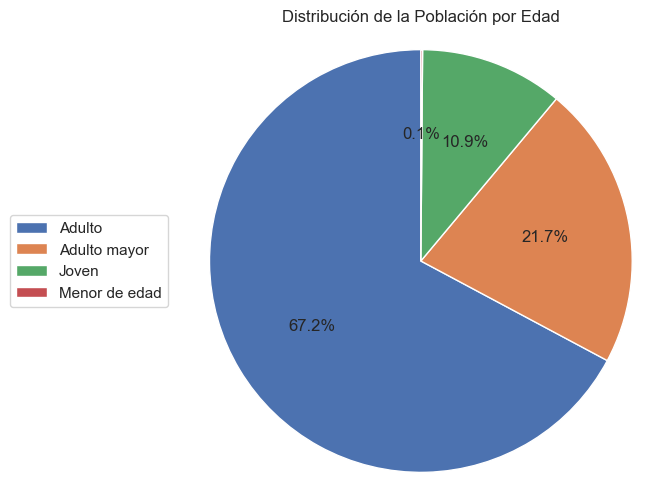

In [17]:
# Clasificar por edades

def clasificar_edades(row):
    if row < 18:
        return 'Menor de edad'
    
    elif 18 <= row < 30:
        return 'Joven'
    
    elif 30 <= row < 60:
        return 'Adulto'
    
    else:
        return 'Adulto mayor'
    

df['categoría_edad'] = df['Edad'].apply(clasificar_edades)

conteo_categoria = df['categoría_edad'].value_counts()

# Crear el gráfico circular
plt.figure(figsize=(6,6))
plt.pie(conteo_categoria, labels=None, autopct='%1.1f%%', startangle=90, labeldistance=1.1)
plt.title('Distribución de la Población por Edad')
plt.axis('equal')  # Para asegurarse de que sea un círculo

# Añadir la leyenda a la izquierda
plt.legend(conteo_categoria.index, loc='center left', bbox_to_anchor=(-0.4, 0.5))

# Mostrar el gráfico
plt.show()